# Analyzing the Optimal Districtsts Start a Restaurant Business in Paris


In [2]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

     |████████████████████████████████| 102kB 7.7MB/s ta 0:00:011
     |████████████████████████████████| 102kB 10.5MB/s ta 0:00:01
All libraries imported.


In [40]:
my_dict = {'1st':'Louvre','2nd':'Bourse','3rd':'Temple','4th':'Hôtel-de-Ville','5th':'Panthéon','6th':'Luxembourg','7th':'Palais-Bourbon','8th':'Élysée','9th':'Opéra','10th':'Entrepôt','11th':'Popincourt','12th':'Reuilly','13th':'Gobelins','14th':'Observatoire','15th':'Vaugirard','16th':'Passy','17th':'Batignolles-Monceau','18th':'Butte-Montmartre','19th':'Buttes-Chaumont','20th':'Ménilmontant'}
df = pd.DataFrame(list(my_dict.items()),columns = ['Dictrict number','Neighborhood']) #I am calling the districts neighborhoods
df

,Dictrict number,Neighborhood
0,1st,Louvre
1,2nd,Bourse
2,3rd,Temple
3,4th,Hôtel-de-Ville
4,5th,Panthéon
5,6th,Luxembourg
6,7th,Palais-Bourbon
7,8th,Élysée
8,9th,Opéra
9,10th,Entrepôt


In [41]:

df['Latitude'] = None
df['Longitude'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Paris, France'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude'] = latitude
    df.loc[i, 'Longitude'] = longitude

df

,Dictrict number,Neighborhood,Latitude,Longitude
0,1st,Louvre,48.861,2.33587
1,2nd,Bourse,48.8691,2.34022
2,3rd,Temple,48.8647,2.36426
3,4th,Hôtel-de-Ville,48.8571,2.35306
4,5th,Panthéon,48.8462,2.34611
5,6th,Luxembourg,48.8476,2.34094
6,7th,Palais-Bourbon,48.8608,2.31859
7,8th,Élysée,48.8693,2.31688
8,9th,Opéra,48.8821,2.32799
9,10th,Entrepôt,48.8422,2.37599


In [14]:
CLIENT_ID = ' YPVTKOPCYL5VI1NOKP5MZZ2NMCWATJK2502GY1MPWCB0PD4I ' 
CLIENT_SECRET = ' VOVPY3V1ZA5B11PMQLKFYAY0ZNROQTY4TCJ1U1GR1LAXZMFO' 
VERSION = '20180604'
LIMIT = 200 #Limit of number of venues
radius=2200

Starting with the first neighborhood

In [42]:
neighborhood_name = df.loc[0, 'Neighborhood']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The district is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The district is Louvre and it's geographical coordinates are 48.86102000000005 latitude and 2.3358700000000567 longitude


In [15]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f8e8b2c349fac2158c1ebe4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Paris',
  'headerFullLocation': 'Paris',
  'headerLocationGranularity': 'city',
  'totalResults': 242,
  'suggestedBounds': {'ne': {'lat': 48.880820019800076,
    'lng': 2.365910155709802},
   'sw': {'lat': 48.84121998020003, 'lng': 2.3058298442903116}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda10f964a520af3521e3',
       'name': 'Musée du Louvre',
       'location': {'address': 'Rue de Rivoli',
        'crossStreet': 'Place du Carrousel',
        'lat': 48.86084691113991,
        'lng': 2.336440086364746,
        'labeledLatLngs': [{'label': 'display',
    

In [16]:
#To get the categories of the venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
#Stores the results in a dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Musée du Louvre,Art Museum,48.860847,2.336440
1,Cour Carrée du Louvre,Pedestrian Plaza,48.860360,2.338543
2,La Vénus de Milo (Vénus de Milo),Exhibit,48.859943,2.337234
3,Vestige de la Forteresse du Louvre,Historic Site,48.861577,2.333508
4,Cour Napoléon,Plaza,48.861172,2.335088


In [18]:
#Now we generalize the procedure for all the enighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
#We now call the function
paris_venues = getNearbyVenues(names=df['District'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Louvre
Bourse
Temple
Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Élysée
Opéra
Entrepôt
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Butte-Montmartre
Buttes-Chaumont
Ménilmontant


In [27]:
#One-hot Encoding to see which categories belong in which neighborhoods
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")
paris_onehot.head()

,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Adding the Neighborhood column to the dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood']
paris_onehot.head()

,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo,Neighborhood
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Louvre
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Louvre
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Louvre
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Louvre
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Louvre


In [30]:
#Moving the neighborhood column to the first column
temp = list(paris_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,...,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Louvre,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Louvre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Louvre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Louvre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Louvre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#We now group by district and take the mean of all the categories
paris_grouped = paris_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(paris_grouped.shape)
paris_grouped

(20, 180)


,Neighborhood,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,...,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Louvre,0.00,0.00,0.02,0.07,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.00,0.02,0.00
1,Bourse,0.00,0.00,0.01,0.07,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.02,0.00
2,Temple,0.00,0.00,0.02,0.02,0.00,0.01,0.00,0.01,0.00,...,0.01,0.00,0.00,0.01,0.00,0.01,0.03,0.01,0.00,0.00
3,Hôtel-de-Ville,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.00,0.01,0.04,0.00,0.01,0.00
4,Panthéon,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
5,Luxembourg,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
6,Palais-Bourbon,0.00,0.00,0.01,0.07,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00
7,Élysée,0.00,0.00,0.01,0.05,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00
8,Opéra,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.01,0.00,0.05,0.01,0.00,0.00
9,Entrepôt,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.01,0.00,0.01,0.00,0.00,0.04,0.01,0.00,0.01


In [33]:
#We have to create a data frame with the top 10 venues for each district
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Louvre,Plaza,Art Museum,Hotel,Bookstore,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Historic Site,Wine Bar,Seafood Restaurant
1,Bourse,Hotel,Plaza,Art Museum,Historic Site,French Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,Boutique,Seafood Restaurant
2,Temple,Bakery,Coffee Shop,Restaurant,French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Bookstore,Sandwich Place,Creperie
3,Hôtel-de-Ville,Cocktail Bar,Plaza,Seafood Restaurant,Wine Bar,Bakery,French Restaurant,Café,Art Gallery,Restaurant,Art Museum
4,Panthéon,Plaza,French Restaurant,Coffee Shop,Wine Bar,Ice Cream Shop,Italian Restaurant,Lebanese Restaurant,Cocktail Bar,Bakery,Pastry Shop
5,Luxembourg,Plaza,French Restaurant,Wine Bar,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Pastry Shop,Lebanese Restaurant,Bakery,Fountain
6,Palais-Bourbon,French Restaurant,Plaza,Hotel,Art Museum,Garden,Historic Site,Boutique,Tailor Shop,Theater,Bookstore
7,Élysée,Hotel,French Restaurant,Plaza,Art Museum,Boutique,Garden,Pastry Shop,Historic Site,Tailor Shop,Cosmetics Shop
8,Opéra,French Restaurant,Italian Restaurant,Bakery,Wine Bar,Plaza,Bar,Pastry Shop,Hotel,Coffee Shop,Bistro
9,Entrepôt,French Restaurant,Cocktail Bar,Wine Bar,Bar,Museum,Plaza,Pedestrian Plaza,Bistro,Beer Garden,Italian Restaurant


Clustering neighborhoods

In [35]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [36]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = paris_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) 
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[0.7269607237282985, 0.25011680940091674, 0.18136128555573666, 0.1751733543825147, 0.21369723193372314, 0.21969079507691433, 0.23338702625589644, 0.25796320861872585, 0.2592612183813519, 0.25797091959187923, 0.2647598449998172, 0.22656939453413175, 0.19780814549332087, 0.17140196002378497]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


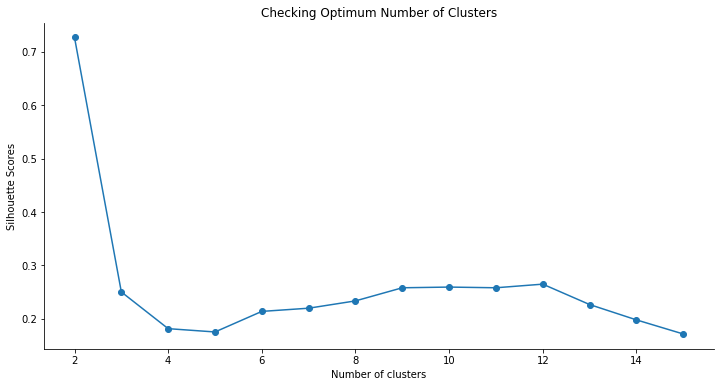

In [37]:
#Shows the graph for the optimal number of clusters
print(scores)
print(kval)
plot(kval, scores)

In [45]:
k = 2

paris_clustering = paris_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(paris_clustering) 

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int32)

In [ ]:
#Create data frame including labels and top 10 venues
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
paris_merged = df
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [51]:
paris_merged

,Dictrict number,Neighborhood,Latitude,Longitude,Labels,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1st,Louvre,48.861,2.33587,0,0,Plaza,Art Museum,Hotel,Bookstore,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Historic Site,Wine Bar,Seafood Restaurant
1,2nd,Bourse,48.8691,2.34022,0,0,Hotel,Plaza,Art Museum,Historic Site,French Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,Boutique,Seafood Restaurant
2,3rd,Temple,48.8647,2.36426,0,0,Bakery,Coffee Shop,Restaurant,French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Bookstore,Sandwich Place,Creperie
3,4th,Hôtel-de-Ville,48.8571,2.35306,0,0,Cocktail Bar,Plaza,Seafood Restaurant,Wine Bar,Bakery,French Restaurant,Café,Art Gallery,Restaurant,Art Museum
4,5th,Panthéon,48.8462,2.34611,0,0,Plaza,French Restaurant,Coffee Shop,Wine Bar,Ice Cream Shop,Italian Restaurant,Lebanese Restaurant,Cocktail Bar,Bakery,Pastry Shop
5,6th,Luxembourg,48.8476,2.34094,0,0,Plaza,French Restaurant,Wine Bar,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Pastry Shop,Lebanese Restaurant,Bakery,Fountain
6,7th,Palais-Bourbon,48.8608,2.31859,0,0,French Restaurant,Plaza,Hotel,Art Museum,Garden,Historic Site,Boutique,Tailor Shop,Theater,Bookstore
7,8th,Élysée,48.8693,2.31688,0,0,Hotel,French Restaurant,Plaza,Art Museum,Boutique,Garden,Pastry Shop,Historic Site,Tailor Shop,Cosmetics Shop
8,9th,Opéra,48.8821,2.32799,0,0,French Restaurant,Italian Restaurant,Bakery,Wine Bar,Plaza,Bar,Pastry Shop,Hotel,Coffee Shop,Bistro
9,10th,Entrepôt,48.8422,2.37599,0,0,French Restaurant,Cocktail Bar,Wine Bar,Bar,Museum,Plaza,Pedestrian Plaza,Bistro,Beer Garden,Italian Restaurant


In [52]:
#Visualizing the clusters on the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [54]:
#Data frame of cluster 1
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[0] + [1] + list(range(5, paris_merged.shape[1]))]]

,Dictrict number,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1st,Louvre,0,Plaza,Art Museum,Hotel,Bookstore,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Historic Site,Wine Bar,Seafood Restaurant
1,2nd,Bourse,0,Hotel,Plaza,Art Museum,Historic Site,French Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,Boutique,Seafood Restaurant
2,3rd,Temple,0,Bakery,Coffee Shop,Restaurant,French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Bookstore,Sandwich Place,Creperie
3,4th,Hôtel-de-Ville,0,Cocktail Bar,Plaza,Seafood Restaurant,Wine Bar,Bakery,French Restaurant,Café,Art Gallery,Restaurant,Art Museum
4,5th,Panthéon,0,Plaza,French Restaurant,Coffee Shop,Wine Bar,Ice Cream Shop,Italian Restaurant,Lebanese Restaurant,Cocktail Bar,Bakery,Pastry Shop
5,6th,Luxembourg,0,Plaza,French Restaurant,Wine Bar,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Pastry Shop,Lebanese Restaurant,Bakery,Fountain
6,7th,Palais-Bourbon,0,French Restaurant,Plaza,Hotel,Art Museum,Garden,Historic Site,Boutique,Tailor Shop,Theater,Bookstore
7,8th,Élysée,0,Hotel,French Restaurant,Plaza,Art Museum,Boutique,Garden,Pastry Shop,Historic Site,Tailor Shop,Cosmetics Shop
8,9th,Opéra,0,French Restaurant,Italian Restaurant,Bakery,Wine Bar,Plaza,Bar,Pastry Shop,Hotel,Coffee Shop,Bistro
9,10th,Entrepôt,0,French Restaurant,Cocktail Bar,Wine Bar,Bar,Museum,Plaza,Pedestrian Plaza,Bistro,Beer Garden,Italian Restaurant


In [56]:
#Data frame of cluster 2
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[0] + [1] + list(range(5, paris_merged.shape[1]))]]

,Dictrict number,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,16th,Passy,1,Scenic Lookout,Restaurant,Zoo,Ethiopian Restaurant,Escape Room,Electronics Store,Drive-in Theater,Dim Sum Restaurant,Dessert Shop,Department Store


In [58]:
#Data frame of districts where I should open a restaurant
new_restaurant_neighborhoods = paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[0, 1, 2, 3] + list(range(5, paris_merged.shape[1]))]]
new_restaurant_neighborhoods

,Dictrict number,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1st,Louvre,48.861,2.33587,0,Plaza,Art Museum,Hotel,Bookstore,Cocktail Bar,Ice Cream Shop,Italian Restaurant,Historic Site,Wine Bar,Seafood Restaurant
1,2nd,Bourse,48.8691,2.34022,0,Hotel,Plaza,Art Museum,Historic Site,French Restaurant,Cocktail Bar,Ice Cream Shop,Bakery,Boutique,Seafood Restaurant
2,3rd,Temple,48.8647,2.36426,0,Bakery,Coffee Shop,Restaurant,French Restaurant,Cocktail Bar,Italian Restaurant,Wine Bar,Bookstore,Sandwich Place,Creperie
3,4th,Hôtel-de-Ville,48.8571,2.35306,0,Cocktail Bar,Plaza,Seafood Restaurant,Wine Bar,Bakery,French Restaurant,Café,Art Gallery,Restaurant,Art Museum
4,5th,Panthéon,48.8462,2.34611,0,Plaza,French Restaurant,Coffee Shop,Wine Bar,Ice Cream Shop,Italian Restaurant,Lebanese Restaurant,Cocktail Bar,Bakery,Pastry Shop
5,6th,Luxembourg,48.8476,2.34094,0,Plaza,French Restaurant,Wine Bar,Ice Cream Shop,Italian Restaurant,Cocktail Bar,Pastry Shop,Lebanese Restaurant,Bakery,Fountain
6,7th,Palais-Bourbon,48.8608,2.31859,0,French Restaurant,Plaza,Hotel,Art Museum,Garden,Historic Site,Boutique,Tailor Shop,Theater,Bookstore
7,8th,Élysée,48.8693,2.31688,0,Hotel,French Restaurant,Plaza,Art Museum,Boutique,Garden,Pastry Shop,Historic Site,Tailor Shop,Cosmetics Shop
8,9th,Opéra,48.8821,2.32799,0,French Restaurant,Italian Restaurant,Bakery,Wine Bar,Plaza,Bar,Pastry Shop,Hotel,Coffee Shop,Bistro
9,10th,Entrepôt,48.8422,2.37599,0,French Restaurant,Cocktail Bar,Wine Bar,Bar,Museum,Plaza,Pedestrian Plaza,Bistro,Beer Garden,Italian Restaurant
